# Summary



---
# Setup


In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from popy.neural_value_helpers import plot_Vt_per_sequence, create_r_style_plot, get_cpd_all, create_permutation_null, plot_cpds_history_neural_value
from popy.config import COLORS, PROJECT_PATH_LOCAL

plt.rcParams.update({'font.size': 8})


In [2]:
# local functions
def normalize_behavioral_values(behav):
    # normalize dV and V_t per monkey, session, subregion
    behav[f'V_t'] = behav.groupby(['monkey', 'session', 'subregion'])[f'V_t'].transform(lambda x: (x - x.mean()) / x.std())
    behav[f'V_t_p1'] = behav.groupby(['monkey', 'session', 'subregion'])[f'V_t_p1'].transform(lambda x: (x - x.mean()) / x.std())
    behav[f'dV'] = behav[f'V_t_p1'] - behav[f'V_t']

    return behav

def sum_behav_stats(behav):
    behav_sess_avg_fb = []
    for (monkey, session, subregion), group in behav.groupby(['monkey', 'session', 'subregion']):
        U, pval = stats.mannwhitneyu(group.loc[group['feedback'] == 0, 'dV'], group.loc[group['feedback'] == 1, 'dV'], alternative='two-sided')
        for fb in group['feedback'].unique():
            behav_sess_avg_fb.append({
                'monkey': monkey,
                'session': session,
                'subregion': subregion,
                'feedback': fb,
                'V_t': group.loc[group['feedback'] == fb, 'V_t'].mean(),
                'V_t_p1': group.loc[group['feedback'] == fb, 'V_t_p1'].mean(),
                'dV': group.loc[group['feedback'] == fb, 'dV'].mean(),
                'U': U,
                'signif': pval < 0.05
            })
    behav_sess_avg_fb = pd.DataFrame(behav_sess_avg_fb)
    
    return behav_sess_avg_fb    


---
# Get data (load from file)


In [3]:
behav = pd.read_pickle(os.path.join(PROJECT_PATH_LOCAL, 'data', 'results', 'behav_neural_value', 'behav.pkl'))
behav = behav.dropna(subset=['V_t_p1'])  # not every trial has a next trial (i.e., last trial in session, trials before interrupted trials, etc), these are assigned with nans, drop them
behav = normalize_behavioral_values(behav)
behav

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zsombi/Desktop/bandit_sbri/data/results/behav_neural_value/behav.pkl'

---
# Create figures

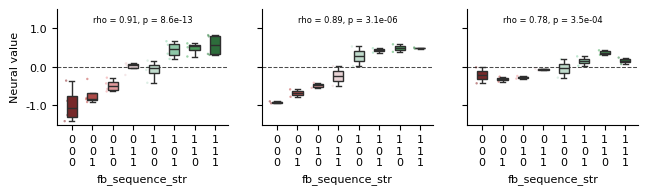

In [ ]:
# setup figure
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(1, 3, figsize=(7.5, 1.5), sharex=True, sharey=True)

# for each monkey, session, subregion, fb_sequence, take a mean of these columns
behav_sess_avg_sequence = behav.copy().groupby(['monkey', 'session', 'subregion', 'fb_sequence'])['V_t'].mean().reset_index()

for s, subregion in enumerate(behav['subregion'].unique()):
    # get data for this subregion
    behav_sess_avg_sequence_temp = behav_sess_avg_sequence.loc[behav_sess_avg_sequence['subregion'] == subregion]

    # plot
    plot_Vt_per_sequence(behav_sess_avg_sequence_temp, paper_format=True, ylim=[-1.5, 1.5], show_datapoints=True, showfliers=False, ax=axs[s])


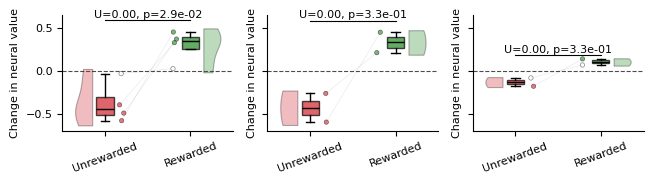

In [ ]:
# setup figure
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(1, 3, figsize=(7.5, 1.5), sharex=True, sharey=True)

behav_sess_avg_fb = sum_behav_stats(behav)

for s, subregion in enumerate(behav['subregion'].unique()):
    behav_sess_avg_feed_temp = behav_sess_avg_fb.loc[behav_sess_avg_fb['subregion'] == subregion]

    create_r_style_plot(axs[s], behav_sess_avg_feed_temp, 'feedback', 'dV')


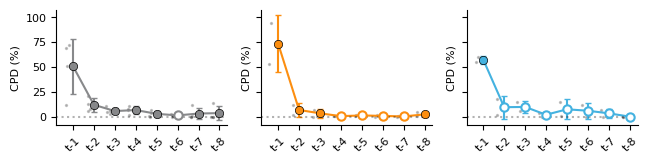

In [ ]:
# setup figure
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(1, 3, figsize=(7.5, 1.5), sharex=True, sharey=True)

n_perms = 500  # number of permutations for CPD analysis

# Main analysis with joblib parallelization
cpd_all = get_cpd_all(behav, n_perms)

for s, subregion in enumerate(behav['subregion'].unique()):
    cpd_all_temp = cpd_all.loc[cpd_all['subregion'] == subregion]
    null_temp = create_permutation_null(behav.loc[behav['subregion'] == subregion], n_perms=n_perms)

    plot_cpds_history_neural_value(cpd_all_temp, null_temp, ax=axs[s], show_data=True)
